# Embedding Models

Resource: https://www.deeplearning.ai/short-courses/embedding-models-from-architecture-to-implementation/

### Get embeddings

In [41]:
import gensim.downloader as api

word_vectors = api.load("glove-wiki-gigaword-100")

### Check embeddings

In [42]:
word_vectors["king"].shape

(100,)

In [43]:
word_vectors["king"][:20]

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

### Visualize words

In [44]:
import numpy as np

# Words to visualize
words = ["king", "princess", "monarch", "throne", "crown", "mountain", "ocean", "tv", "rainbow", "cloud", "queen"]

# Get word vectors
vectors = np.array([word_vectors[word] for word in words])

In [45]:
from sklearn.decomposition import PCA

# Reduce dimensions
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

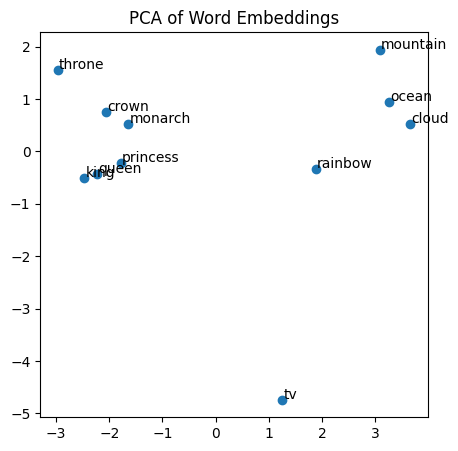

In [46]:
import matplotlib.pyplot as plt

# Plot
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0] + 0.02, vectors_pca[i, 1] + 0.02))
axes.set_title("PCA of Word Embeddings")
plt.show()

### Embeddings operations

In [47]:
result = word_vectors.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=1
)

print(f"The word closest to 'king' - 'man' + 'woman' is: '{result[0][0]}' with a similarity score of {result[0][1]}""")

The word closest to 'king' - 'man' + 'woman' is: 'queen' with a similarity score of 0.7698541283607483


### Compare GloVe and BERT

In [48]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")  

In [49]:
# Get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    
    last_hidden_state = outputs.last_hidden_state
    
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_state[0, word_index + 1, :]
    
    return word_embedding

In [50]:
sentence_1 = "The bat flew out of the cave at night."
sentence_2 = "He swung the bat and hit a home run."

word = "bat"

bert_embedding_1 = get_bert_embeddings(sentence_1, word)
bert_embedding_2 = get_bert_embeddings(sentence_2, word)
word_embedding = word_vectors[word]

/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [51]:
print(f"BERT embedding for 'bat' in sentence 1: {bert_embedding_1[:5]}")
print(f"BERT embedding for 'bat' in sentence 2: {bert_embedding_2[:5]}")

BERT embedding for 'bat' in sentence 1: tensor([ 0.4132, -0.1291, -0.4487, -0.4049, -0.1531], grad_fn=<SliceBackward0>)
BERT embedding for 'bat' in sentence 2: tensor([ 0.6407, -0.3112, -0.4409, -0.1655, -0.2006], grad_fn=<SliceBackward0>)


In [52]:
from sklearn.metrics.pairwise import cosine_similarity

bert_similarity = cosine_similarity(
    [bert_embedding_1.detach().numpy()], 
    [bert_embedding_2.detach().numpy()]
)[0][0]

glove_similarity = cosine_similarity(
    [word_embedding],
    [word_embedding]
)[0][0]

print(f"Cosine similarity between BERT embeddings in different contextes: {bert_similarity}")
print(f"Cosine similarity between GloVe embeddings: {glove_similarity}")

Cosine similarity between BERT embeddings in different contextes: 0.4599575698375702
Cosine similarity between GloVe embeddings: 1.0


### Cross Encoder

In [53]:
from sentence_transformers import CrossEncoder
import torch

model = CrossEncoder(
    model_name_or_path="cross-encoder/ms-marco-MiniLM-L-6-v2", 
    max_length=512, 
    activation_fn=torch.nn.Sigmoid()
)

In [54]:
question = "Where ist the capitla of Germany"
answers = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain."
]

In [55]:
scores = model.predict(
    [
        (question, answers[0]),
        (question, answers[1]),
        (question, answers[2])
    ]
)
print(scores)

[1.4046593e-05 1.6110415e-03 1.3391236e-05]


/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [56]:
most_relevant_idx = torch.argmax(torch.tensor(scores)).item()
print(f"The most relevant answer is: '{answers[most_relevant_idx]}'")

The most relevant answer is: 'Berlin is the capital of Germany.'


### Token embeddings

In [71]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

In [61]:
def get_sentence_embedding(sentence):
    encoded_input = tokenizer(sentence, padding=True, return_tensors="pt")
    attention_mask = encoded_input["attention_mask"]
    
    with torch.inference_mode():
        output = model(**encoded_input)
        
    token_embeddings = output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(dim=-1).expand(token_embeddings.size()).float()
    
    sentence_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    return sentence_embedding.flatten().tolist()

In [72]:
def cosine_similarity_matrix(featuers):
    norms = np.linalg.norm(
        featuers,
        axis=1,
        keepdims=True,
    )
    normalized_featuers = featuers / norms
    
    similarity_matrix = np.inner(normalized_featuers, normalized_featuers)    
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    
    return rounded_similarity_matrix

In [73]:
import seaborn as sns

def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1.2)
    g = sns.heatmap(
        sim, 
        xticklabels=labels, 
        yticklabels=labels, 
        vmin=0, 
        vmax=1, 
        cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similairyt")
    return g

/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


<Axes: title={'center': 'Semantic Textual Similairyt'}>

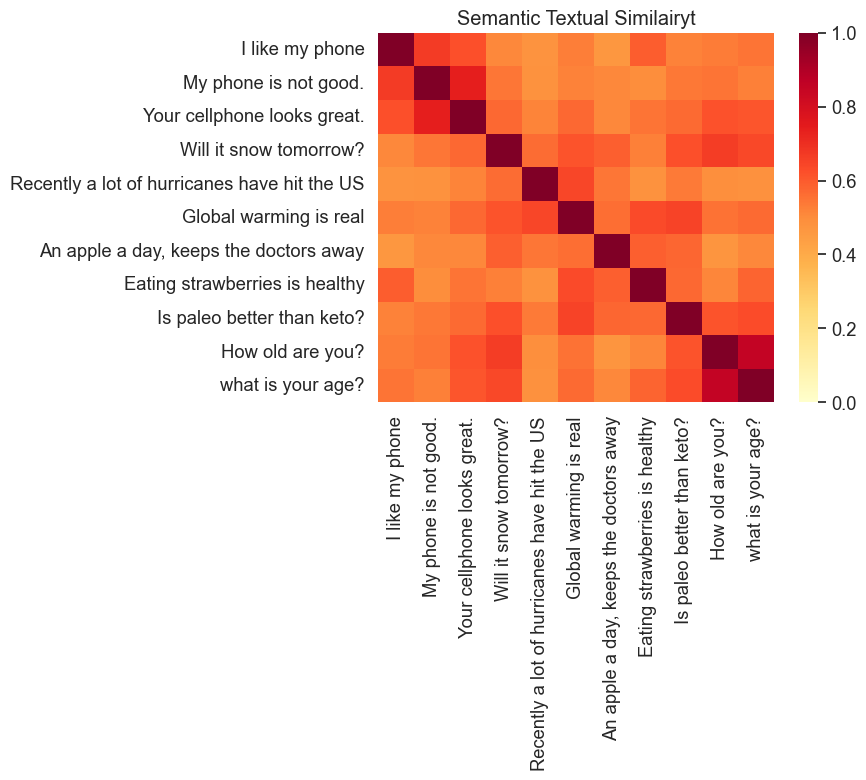

In [74]:
messages = [
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    "How old are you?",
    "what is your age?",
]

embeddings = [
    get_sentence_embedding(t) for t in messages
]

plot_similarity(messages, embeddings, 90)

In [77]:
from datasets import load_dataset
import pandas as pd

sts_dataset = load_dataset("mteb/stsbenchmark-sts")
sts = pd.DataFrame({
    'sentence_1': sts_dataset['test']['sentence1'], 
    'sentence_2': sts_dataset['test']['sentence2'],
    'score': [x/5 for x in sts_dataset['test']['score']]
})
sts.head(10)

,sentence_1,sentence_2,score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400
4,A man is playing a harp.,A man is playing a keyboard.,0.3000
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000
7,A man is playing the drums.,A man is playing the guitar.,0.4400
8,A man is playing guitar.,A lady is playing the guitar.,0.4400
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428


In [78]:
def sim_two_sentences(s1, s2):
    emb1 = get_sentence_embedding(s1)
    emb2 = get_sentence_embedding(s2)
    sim = cosine_similarity_matrix(
        np.vstack([emb1, emb2])
    )
    return sim[0, 1]

In [92]:
n_examples = 50
sts = sts.head(n_examples)

In [93]:
sts["avg_bert_score"] = np.vectorize(sim_two_sentences) (sts["sentence_1"], sts["sentence_2"])
sts.head(10)

/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,sentence_1,sentence_2,score,avg_bert_score,mini_LM_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.8052,0.8052
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.7886,0.7886
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9465,0.9465
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.8820,0.8820
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.3556,0.3556
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.5017,0.5017
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.8074,0.8074
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.4757,0.4757
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.6182,0.6182
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.5096,0.5096


### SBERT and Dual Encoders

/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


<Axes: title={'center': 'Semantic Textual Similairyt'}>

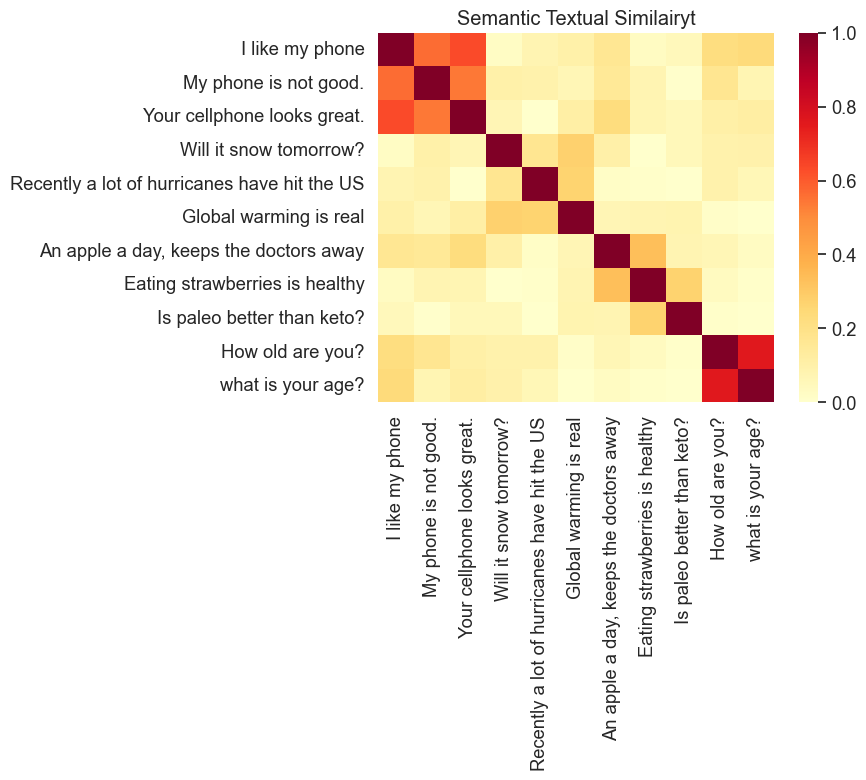

In [107]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = [
    list(model.encode(t)) for t in messages
]

plot_similarity(messages, embeddings, 90)

In [89]:
def sim_two_sentences(s1, s2):
    emb1 = list(model.encode(s1))
    emb2 = list(model.encode(s2))
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

In [91]:
sts['mini_LM_score'] = np.vectorize(sim_two_sentences)(sts['sentence_1'], sts['sentence_2'])
sts.head(10)

/Users/mchojna/Documents/GitHub/llm-playground/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,sentence_1,sentence_2,score,avg_bert_score,mini_LM_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767,0.8052
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615,0.7886
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191,0.9465
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763,0.8820
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472,0.3556
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787,0.5017
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793,0.8074
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730,0.4757
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519,0.6182
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588,0.5096


In [95]:
import scipy

pc = scipy.stats.pearsonr(sts['score'], sts['mini_LM_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.9303740673726042
p-value = 1.4823857251916192e-22


### CrossEntropyLoss 'trick'

In [96]:
df = pd.DataFrame(
    [
        [4.3, 1.2, 0.05, 1.07],
        [0.18, 3.2, 0.09, 0.05],
        [0.85, 0.27, 2.2, 1.03],
        [0.23, 0.57, 0.12, 5.1]
    ]
)
data = torch.tensor(df.values, dtype=torch.float32)

In [97]:
def contrastive_loss(data):
    target = torch.arange(data.size(0))
    loss = torch.nn.CrossEntropyLoss()(data, target)
    return loss

In [98]:
torch.nn.Softmax(dim=1)(data)

tensor([[0.9100, 0.0410, 0.0130, 0.0360],
        [0.0429, 0.8801, 0.0393, 0.0377],
        [0.1512, 0.0846, 0.5832, 0.1810],
        [0.0075, 0.0105, 0.0067, 0.9753]])

In [99]:
torch.nn.Softmax(dim=1)(data).sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000])

In [100]:
N = data.size(0)
non_diag_mask = ~torch.eye(N, N, dtype=bool)

In [101]:
for inx in range(3):
    data = torch.tensor(df.values, dtype=torch.float32)
    data[range(N), range(N)] += inx*0.5
    data[non_diag_mask] -= inx*0.02
    print(data)
    print(f"Loss: {contrastive_loss(data)}")

tensor([[4.3000, 1.2000, 0.0500, 1.0700],
        [0.1800, 3.2000, 0.0900, 0.0500],
        [0.8500, 0.2700, 2.2000, 1.0300],
        [0.2300, 0.5700, 0.1200, 5.1000]])
Loss: 0.19657588005065918
tensor([[4.8000, 1.1800, 0.0300, 1.0500],
        [0.1600, 3.7000, 0.0700, 0.0300],
        [0.8300, 0.2500, 2.7000, 1.0100],
        [0.2100, 0.5500, 0.1000, 5.6000]])
Loss: 0.1260208636522293
tensor([[5.3000, 1.1600, 0.0100, 1.0300],
        [0.1400, 4.2000, 0.0500, 0.0100],
        [0.8100, 0.2300, 3.2000, 0.9900],
        [0.1900, 0.5300, 0.0800, 6.1000]])
Loss: 0.07888656109571457


### Encoder

In [103]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim) -> None:
        super().__init__()
        
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=3,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False,
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        x = self.embedding_layer(tokenizer_output["input_ids"])
        x = self.encoder(
            x,
            src_key_padding_mask=tokenizer_output['attention_mask'].logical_not(),
        )
        cls_embed = x[:, 0, :]
        return self.projection(cls_embed)

In [106]:
from transformers import AutoTokenizer


def train_loop(dataset):
    embed_size=512
    output_embed_size=128
    max_seq_len=64,
    batch_size=32
    
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    question_encoder = Encoder(
        tokenizer.vocab_size,
        embed_size,
        output_embed_size
    )
    answer_encoder = Encoder(
        tokenizer.vocab_size,
        embed_size,
        output_embed_size,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    
    optimizer = torch.optim.Adam(
        list(question_encoder.parameters()) + list(answer_encoder.parameters()),
        lr=1e-5,   
    )
    loss_fn = torch.nn.CrossEntropyLoss()
    
    running_loss = []
    
    for _, data_batch in enumerate(dataloader):
        question, answer = data_batch
        
        question_tok = tokenizer(question, padding=True, truncat=True, return_tensor="pt", max_length=max_seq_len)
        answer_tok = tokenizer(answer, padding=True, truncat=True, return_tensor="pt", max_length=max_seq_len)
        
        question_embed = question_encoder(question_tok)
        answer_embed = answer_encoder(answer_tok)
        
        similarity_scores = question_embed @ answer_embed.T
        target = torch.arange(question_embed.shape[0], dtype=torch.long)
        loss = loss_fn(similarity_scores, target)
        running_loss += [loss.item()]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return question_encoder, answer_encoder

In [128]:
def train(dataset, num_epochs=10):
    embed_size=512
    output_embed_size=128
    max_seq_len=64
    batch_size=32
    
    n_iters = len(dataset) // batch_size + 1
    
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    question_encoder = Encoder(
        tokenizer.vocab_size,
        embed_size,
        output_embed_size
    )
    answer_encoder = Encoder(
        tokenizer.vocab_size,
        embed_size,
        output_embed_size,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    
    optimizer = torch.optim.Adam(
        list(question_encoder.parameters()) + list(answer_encoder.parameters()),
        lr=1e-5,   
    )
    loss_fn = torch.nn.CrossEntropyLoss()    
    
    for epoch in range(num_epochs):
        running_loss = []
        
        for idx, data_batch in enumerate(dataloader):
            question, answer = data_batch
                
            question_tok = tokenizer(question, padding=True, truncation=True, return_tensors='pt', max_length=max_seq_len)
            answer_tok = tokenizer(answer, padding=True, truncation=True, return_tensors='pt', max_length=max_seq_len)
            
            if inx == 0 and epoch == 0:
                print(question_tok['input_ids'].shape, answer_tok['input_ids'].shape)
                
            question_embed = question_encoder(question_tok)
            answer_embed = answer_encoder(answer_tok)
            
            if inx == 0 and epoch == 0:
                print(question_embed.shape, answer_embed.shape)
                
            similarity_scores = question_embed @ answer_embed.T
            
            if inx == 0 and epoch == 0:
                print(similarity_scores.shape)
            
            target = torch.arange(question_embed.shape[0], dtype=torch.long)
            loss = loss_fn(similarity_scores, target)
            running_loss += [loss.item()]
            
            if idx == n_iters-1:
                print(f"Epoch: {epoch} | Loss: {np.mean(running_loss)}")
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return question_encoder, answer_encoder

In [129]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, datapath):
        self.data = pd.read_csv(datapath, sep="\t", nrows=300)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx]["questions"], self.data.iloc[idx]["answers"]

In [130]:
dataset = MyDataset('../data/nq_sample.tsv')
dataset.data.head(5)

,questions,answers
0,who played bubba in the tv series in the heat ...,Carlos Alan Autry Jr. (also known for a period...
1,where did the 2017 tour de france start,"The 3,540 km (2,200 mi)-long race commenced wi..."
2,who is the chess champion of the world,Current world champion Magnus Carlsen won the ...
3,who scored the most hat tricks in football,Cristiano Ronaldo and Messi have scored three ...
4,what do you need to be an ontario scholar,Ontario Scholars are high school graduates in ...


In [131]:
qe, ae = train(dataset, num_epochs=5)

Epoch: 0 | Loss: 3.7521995306015015
Epoch: 1 | Loss: 3.5617685317993164
Epoch: 2 | Loss: 3.4834721803665163
Epoch: 3 | Loss: 3.4111010313034056
Epoch: 4 | Loss: 3.336611104011536


In [132]:
question = 'What is the tallest mountain in the world?'
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
question_tok = tokenizer(question, padding=True, truncation=True, return_tensors='pt', max_length=64)
question_emb = qe(question_tok)[0]
print(question_tok)
print(question_emb[:5])

{'input_ids': tensor([[  101,  2054,  2003,  1996, 13747,  3137,  1999,  1996,  2088,  1029,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([ 0.0617, -0.1858, -0.2735, -0.0327, -0.5816], grad_fn=<SliceBackward0>)


In [133]:
answers = [
    "What is the tallest mountain in the world?",
    "The tallest mountain in the world is Mount Everest.",
    "Who is donald duck?"
]
answer_tok = []
answer_emb = []
for answer in answers:
    tok = tokenizer(answer, padding=True, truncation=True, return_tensors='pt', max_length=64)
    answer_tok.append(tok['input_ids'])
    emb = ae(tok)[0]
    answer_emb.append(emb)

print(answer_tok)
print(answer_emb[0][:5])
print(answer_emb[1][:5])
print(answer_emb[2][:5])

[tensor([[  101,  2054,  2003,  1996, 13747,  3137,  1999,  1996,  2088,  1029,
           102]]), tensor([[  101,  1996, 13747,  3137,  1999,  1996,  2088,  2003,  4057, 23914,
          1012,   102]]), tensor([[ 101, 2040, 2003, 6221, 9457, 1029,  102]])]
tensor([-0.4067, -0.1775,  0.8671,  0.3045, -0.0126], grad_fn=<SliceBackward0>)
tensor([-0.5658, -0.4834,  0.6619,  0.3524, -0.0825], grad_fn=<SliceBackward0>)
tensor([-0.6433, -0.2561,  0.5859,  0.5086,  0.1842], grad_fn=<SliceBackward0>)


In [134]:
question_emb @ torch.stack(answer_emb).T

tensor([-0.3355,  0.2495, -0.7672], grad_fn=<SqueezeBackward4>)

### Inference